In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import genpareto
matplotlib.use('TkAgg')

from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from tqdm.notebook import trange, tqdm
#from anomaly_scoring import get_anomaly_scores

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torchsummary import summary

import torchvision
from torchvision import datasets
from torchvision import transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline 


from utils import get_taxi_data_VAE, get_taxi_data_cVAE
from utils import softclip
from utils import plot_train_test_reconstructions, plot_train_test_reconstructions_prob_decoder_model


In [2]:
class CNN_sigmacVAE(nn.Module):

    def __init__(self,latent_dim=8, window_size=40, cond_window_size=10, use_probabilistic_decoder=False):
        super(CNN_sigmacVAE, self).__init__()
        
        self.window_size=window_size
        self.cond_window_size=cond_window_size
        self.latent_dim = latent_dim
        self.prob_decoder = use_probabilistic_decoder
        
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=6, stride=1, padding=0)
        self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=6, stride=1, padding=0)
        self.bn2 = nn.BatchNorm1d(16)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=4, kernel_size=6, stride=1, padding=0)
        self.bn3 = nn.BatchNorm1d(4)
        
        
        self.fc41 = nn.Linear(4*15, self.latent_dim)
        self.fc42 = nn.Linear(4*15, self.latent_dim)

        self.defc1 = nn.Linear(self.latent_dim + self.cond_window_size, 4*15)
        
        self.deconv1 = nn.ConvTranspose1d(in_channels=4, out_channels=16, kernel_size=2, stride=1, padding=0, output_padding=0)
        self.debn1 = nn.BatchNorm1d(16)
        self.deconv2 = nn.ConvTranspose1d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=0, output_padding=0)
        self.debn2 = nn.BatchNorm1d(8)
        self.deconv3 = nn.ConvTranspose1d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=0, output_padding=0)

        self.log_sigma = 0
        self.log_sigma = torch.nn.Parameter(torch.full((1,), 0.0)[0], requires_grad=True)
        
        
        self.decoder_fc41 = nn.Linear(self.window_size, self.window_size)
        self.decoder_fc42 = nn.Linear(self.window_size, self.window_size)
        
        self.decoder_fc43 = nn.Linear(self.window_size, self.window_size)
        self.decoder_fc44 = nn.Linear(self.window_size, self.window_size)
        
        
    def encoder(self, x, c):
        concat_input = torch.cat([x, c], 2)
        h = self.bn1(F.relu(self.conv1(concat_input)))
        h = self.bn2(F.relu(self.conv2(h)))
        h = self.bn3(F.relu(self.conv3(h)))
        
        self.saved_dim = [h.size(1), h.size(2)]
        
        h = h.view(h.size(0), h.size(1) * h.size(2))

        return self.fc41(h), self.fc42(h)
    
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu) # return z sample
    
    def decoder(self, z, c):
        c = c.view(c.size(0), -1)
        concat_input = torch.cat([z, c], 1)
        concat_input = self.defc1(concat_input)
        concat_input = concat_input.view(concat_input.size(0), self.saved_dim[0], self.saved_dim[1])

        h = self.debn1(F.relu(self.deconv1(concat_input)))
        h = self.debn2(F.relu(self.deconv2(h)))     
        out = torch.sigmoid(self.deconv3(h))
        
        if self.prob_decoder:
            rec_mu = self.decoder_fc43(out).tanh()
            rec_sigma = self.decoder_fc44(out).tanh()
            return out, rec_mu, rec_sigma
        
        else:
            return out, 0, 0
    
    def forward(self, x, c):

        mu, log_var = self.encoder(x, c)

        z = self.sampling(mu, log_var)
        output, rec_mu, rec_sigma = self.decoder(z, c)

        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        return output, rec_mu, rec_sigma, kl_div


    def gaussian_nll(self, mu, log_sigma, x):
        return 0.5 * torch.pow((x - mu) / log_sigma.exp(), 2) + log_sigma + 0.5 * np.log(2 * np.pi)

    
    def reconstruction_loss(self, x_hat, x):

        log_sigma = self.log_sigma
        log_sigma = softclip(log_sigma, -6)
        
        rec_comps = self.gaussian_nll(x_hat, log_sigma, x)
        rec = rec_comps.sum()

        return rec_comps, rec

    
    def loss_function(self, recon_x, x, rec_mu, rec_sigma, kl):
        
        rec_comps, rec = self.reconstruction_loss(recon_x, x)
        #kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        rec_mu_sigma_loss = 0
        if self.prob_decoder:
            rec_mu_sigma_loss = self.gaussian_nll(rec_mu, rec_sigma, x).sum()
        
        return rec_comps, rec, rec_mu_sigma_loss, kl


torch.Size([514, 1, 20]) torch.Size([514, 1, 10])
torch.Size([515, 1, 20]) torch.Size([515, 1, 10])


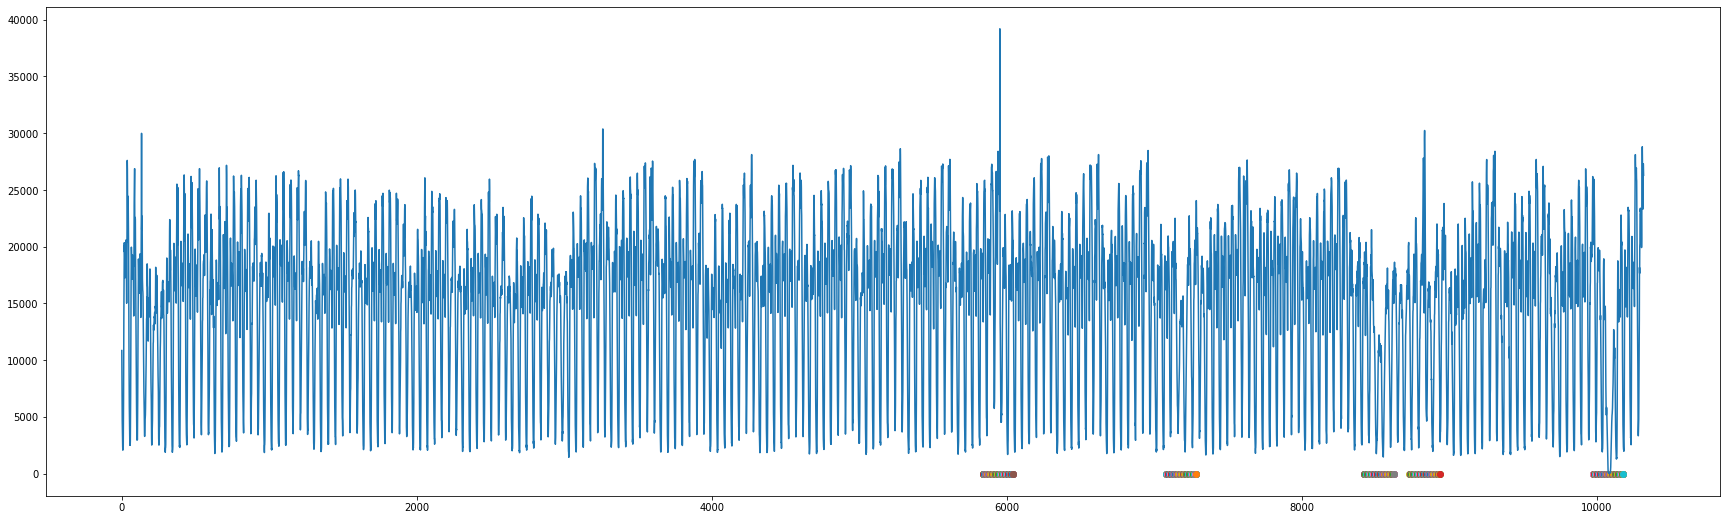

In [3]:
dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/nyc_taxi.csv'
#dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/machine_temperature_system_failure.csv'
#dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/ambient_temperature_system_failure.csv'
#dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/cpu_utilization_asg_misconfiguration.csv'
#dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/ec2_request_latency_system_failure.csv'


if 'nyc_taxi' in dataset_path:
    anomaly_timestamps = ["2014-11-01 19:00:00", "2014-11-27 15:30:00","2014-12-25 15:00:00","2015-01-01 01:00:00","2015-01-27 00:00:00"]

    anomaly_windows = [
        [
            "2014-10-30 15:30:00",
            "2014-11-03 22:30:00"
        ],
        [
            "2014-11-25 12:00:00",
            "2014-11-29 19:00:00"
        ],
        [
            "2014-12-23 11:30:00",
            "2014-12-27 18:30:00"
        ],
        [
            "2014-12-29 21:30:00",
            "2015-01-03 04:30:00"
        ],
        [
            "2015-01-24 20:30:00",
            "2015-01-29 03:30:00"
        ]
    ]
    
elif 'ambient_temperature_system_failure' in dataset_path:
    anomaly_timestamps = ["2013-12-22 20:00:00","2014-04-13 09:00:00"]

elif 'cpu_utilization_asg_misconfiguration' in dataset_path:
    anomaly_timestamps = ["2014-07-12 02:04:00","2014-07-14 21:44:00"]

elif 'ec2_request_latency_system_failure' in dataset_path:
    anomaly_timestamps = ["2014-03-14 09:06:00","2014-03-18 22:41:00","2014-03-21 03:01:00"]

elif 'machine_temperature_system_failure' in dataset_path:
    anomaly_timestamps = ["2013-12-11 06:00:00","2013-12-16 17:25:00","2014-01-28 13:55:00","2014-02-08 14:30:00"]

    

    
#singular anomaly points
'''
window_size=128
X_train_data, X_test_data, X_train_tensor, X_test_tensor, trainloader, testloader = get_taxi_data_VAE(dataset_path,window_size=window_size,train_test_split=.5) 

data = pd.read_csv(dataset_path)

timestamps = list(pd.read_csv(dataset_path)['timestamp'])
    
anomaly_idxs = []
for timestamp in anomaly_timestamps:
    start = timestamp

    loc_start = timestamps.index(start)
    anomaly_idxs.append(loc_start)
    
anomaly_idxs = np.array(anomaly_idxs)    
'''



#anomaly windows code -- not used currently -- what are anomaly windows in nab??

window_size=20
cond_window_size=10
X_train_data, X_test_data, X_train_tensor, cond_train_tensor, X_test_tensor, cond_test_tensor, trainloader, testloader = get_taxi_data_cVAE(dataset_path,window_size=window_size,cond_window_size=cond_window_size,train_test_split=.5) 

data = pd.read_csv(dataset_path)

timestamps = list(pd.read_csv(dataset_path)['timestamp'])

anomaly_idxs = []
for timestamp in anomaly_windows:
    start, end = timestamp[0], timestamp[1]

    loc_start = timestamps.index(start)
    loc_end = timestamps.index(end)

    for i in range(loc_start, loc_end):
        anomaly_idxs.append(i)

anomaly_idxs = np.array(anomaly_idxs)
anomaly_idxs = anomaly_idxs[anomaly_idxs > 0]

plt.figure(figsize=(30,9))
for ai in anomaly_idxs:
    plt.scatter(ai, 1.7)


plt.plot(data['value'])
plt.show()


In [4]:
def train_model(model, num_epochs, learning_rate, dataloader):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epochs=num_epochs
    tq = tqdm(range(epochs))
    for epoch in tq:
        flag = False
        for j, data in enumerate(dataloader, 0):

            model.train()
            
            optimizer.zero_grad()

            #batches
            inputs, cond = data
            inputs.to(device)
            cond.to(device)

            outputs, rec_mu, rec_sigma, kl = model(inputs, cond)

            rec_comps, rec, rec_mu_sigma_loss, kl = model.loss_function(outputs, inputs, rec_mu, rec_sigma, kl)

            loss = rec + kl + rec_mu_sigma_loss

            if(np.isnan(loss.item())):
                print("Noped out at", epoch, j, kl, rec_comps)
                flag = True
                break

            loss.backward()
            optimizer.step()
        if(flag):
            break
        tq.set_postfix(loss=loss.item())
        #print(epoch, 'total :' + str(loss.item()) + ' rec : ' + str(rec.item()) + ' kl : ' + str(kl.sum().item()) + ' sigma: ' + str(model.log_sigma.item()))

        #break
    return model

In [5]:
latent_dim=8
model = CNN_sigmacVAE(latent_dim=latent_dim, window_size=window_size, use_probabilistic_decoder=False)
model.to(device)
model.cuda() if torch.cuda.is_available() else model.cpu()

model = train_model(model, 1000, .001, trainloader)

In [6]:
def plot_cvae(model, X_train_tensor, X_train_data, X_test_tensor, X_test_data, cond_train_tensor, cond_test_tensor, window_size, cond_window_size):
    torch.no_grad()

    
    #train data
    output, _,_,_= model(X_train_tensor, cond_train_tensor)
    output = output.detach().numpy()
    print(output.shape)

    idx = 0
    preds = []
    for i in range(len(output)):
        for j in output[i,0, :cond_window_size]:
            preds.append(j)
    
    plt.figure(figsize=(30,9))
    plt.plot(X_train_data[cond_window_size:-cond_window_size],label='real')
    plt.plot(preds,label='pred')
    plt.legend()

    plt.show()
    
    train_squared_error = mean_squared_error(X_train_data[cond_window_size:-cond_window_size], preds) * len(preds)

    
    #test data

    output, _,_,_= model(X_test_tensor, cond_test_tensor)
    output = output.detach().numpy()
    print(output.shape)

    idx = 0
    preds = []
    for i in range(len(output)):
        for j in output[i,0, :cond_window_size]:
            preds.append(j)



    plt.figure(figsize=(30,9))
    plt.plot(X_test_data[:-cond_window_size],label='real')
    plt.plot(preds,label='pred')
    plt.legend()

    plt.show()

    
    test_squared_error = mean_squared_error(X_test_data[:-cond_window_size], preds) * len(preds)

    print('train MSE : ' + str(np.round(train_squared_error,3)) + ' test MSE : ' + str(np.round(test_squared_error,3)))


torch.Size([515, 1, 20])
torch.Size([515, 1, 10])
(514, 1, 20)


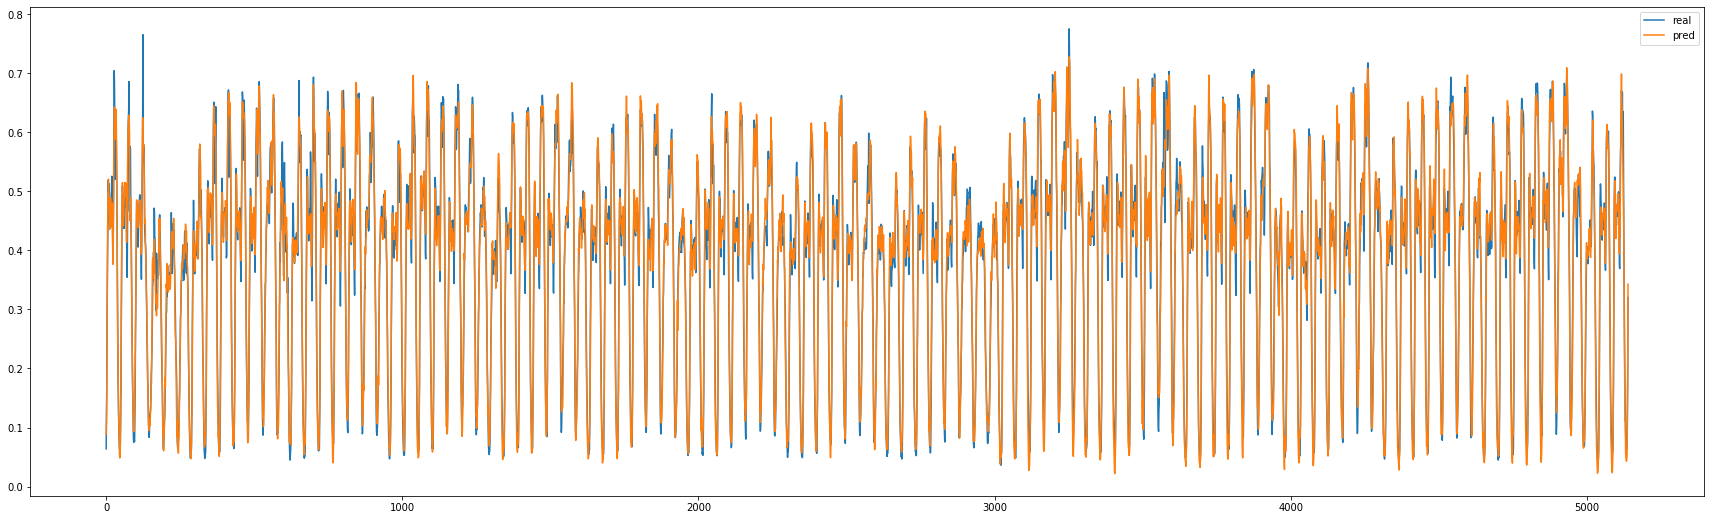

(515, 1, 20)


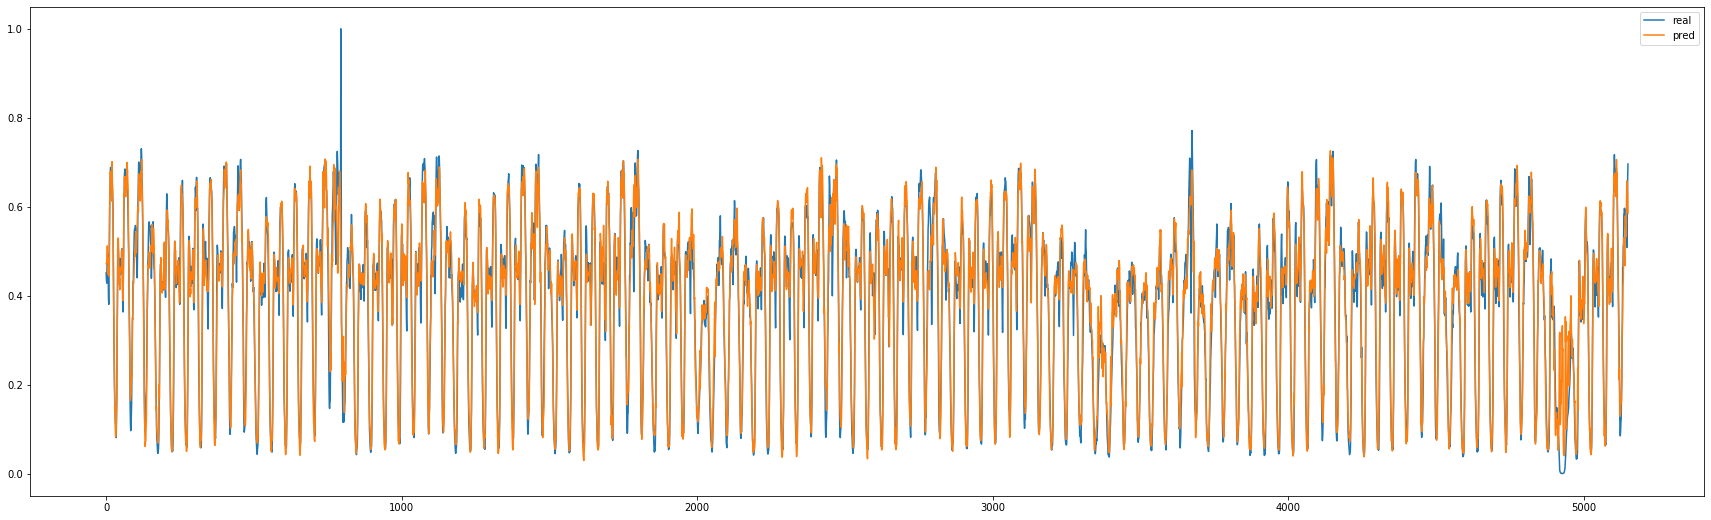

train MSE : 4.094 test MSE : 9.373


In [7]:
print(X_test_tensor.shape)
print(cond_test_tensor.shape)

plot_cvae(model, X_train_tensor, X_train_data, X_test_tensor, X_test_data, cond_train_tensor, cond_test_tensor, window_size, cond_window_size) 


# Evaluation

In [14]:
def evaluate_model(model, X_tensor, c):
    
    X_tensor = X_tensor.cuda() if torch.cuda.is_available() else X_tensor.cpu()
    X_tensor.to(device)
    output, _,_,_= model(X_test_tensor, c)
    output = output.detach().numpy()

    idx = 0
    preds = []
    for i in range(len(output)):
        for j in output[i,0, :cond_window_size]:
            preds.append(j)



    preds = np.array(preds)
    
    return preds

'''
returns adjusted predictions (like DONUT method) (all others paper use this I believe also)
'''
def evaluate_anomalies(real, scores, thresh):
    
    pointwise_alerts = np.array([1 if scores[i] > thresh else 0 for i in range(len(scores))])

    anomaly_windows = []
    i = 0
    while i < len(real):
        if real[i] == 1:
            j = i
            while(j < len(real)):
                if real[j] == 0:
                    anomaly_windows.append([i,j])
                    break
                j+=1

                if j == len(real)-1 and real[j] == 1:
                    anomaly_windows.append([i,j+1])
                    break                

            i = j-1

        i+=1

    adjusted_alerts = np.copy(pointwise_alerts)
    for aw in anomaly_windows:
        if pointwise_alerts[aw[0]:aw[1]].any() == 1:
            adjusted_alerts[aw[0]:aw[1]] = 1


    return adjusted_alerts


def plot_error_and_anomaly_idxs(real, preds, anomaly_idxs):

    plt.figure(figsize=(50,15))
    plt.plot(real)
    plt.plot(preds)
    for ai in anomaly_idxs:
        plt.plot(ai, 1)
    plt.show()
    
    plt.figure(figsize=(50,15))
    scores = (preds - real[:len(preds)])**2
    for idx,ai in enumerate(anomaly_idxs):
        plt.scatter(ai, scores[ai], color='red')
    plt.plot(scores)
    plt.show()

In [15]:
real = np.zeros(len(X_test_data), dtype=np.int)
anomaly_idxs_test = anomaly_idxs - len(X_train_data)
real[anomaly_idxs_test] = 1

preds = evaluate_model(model, X_test_tensor, cond_test_tensor)

print(len(preds))

(515, 1, 20)
5150


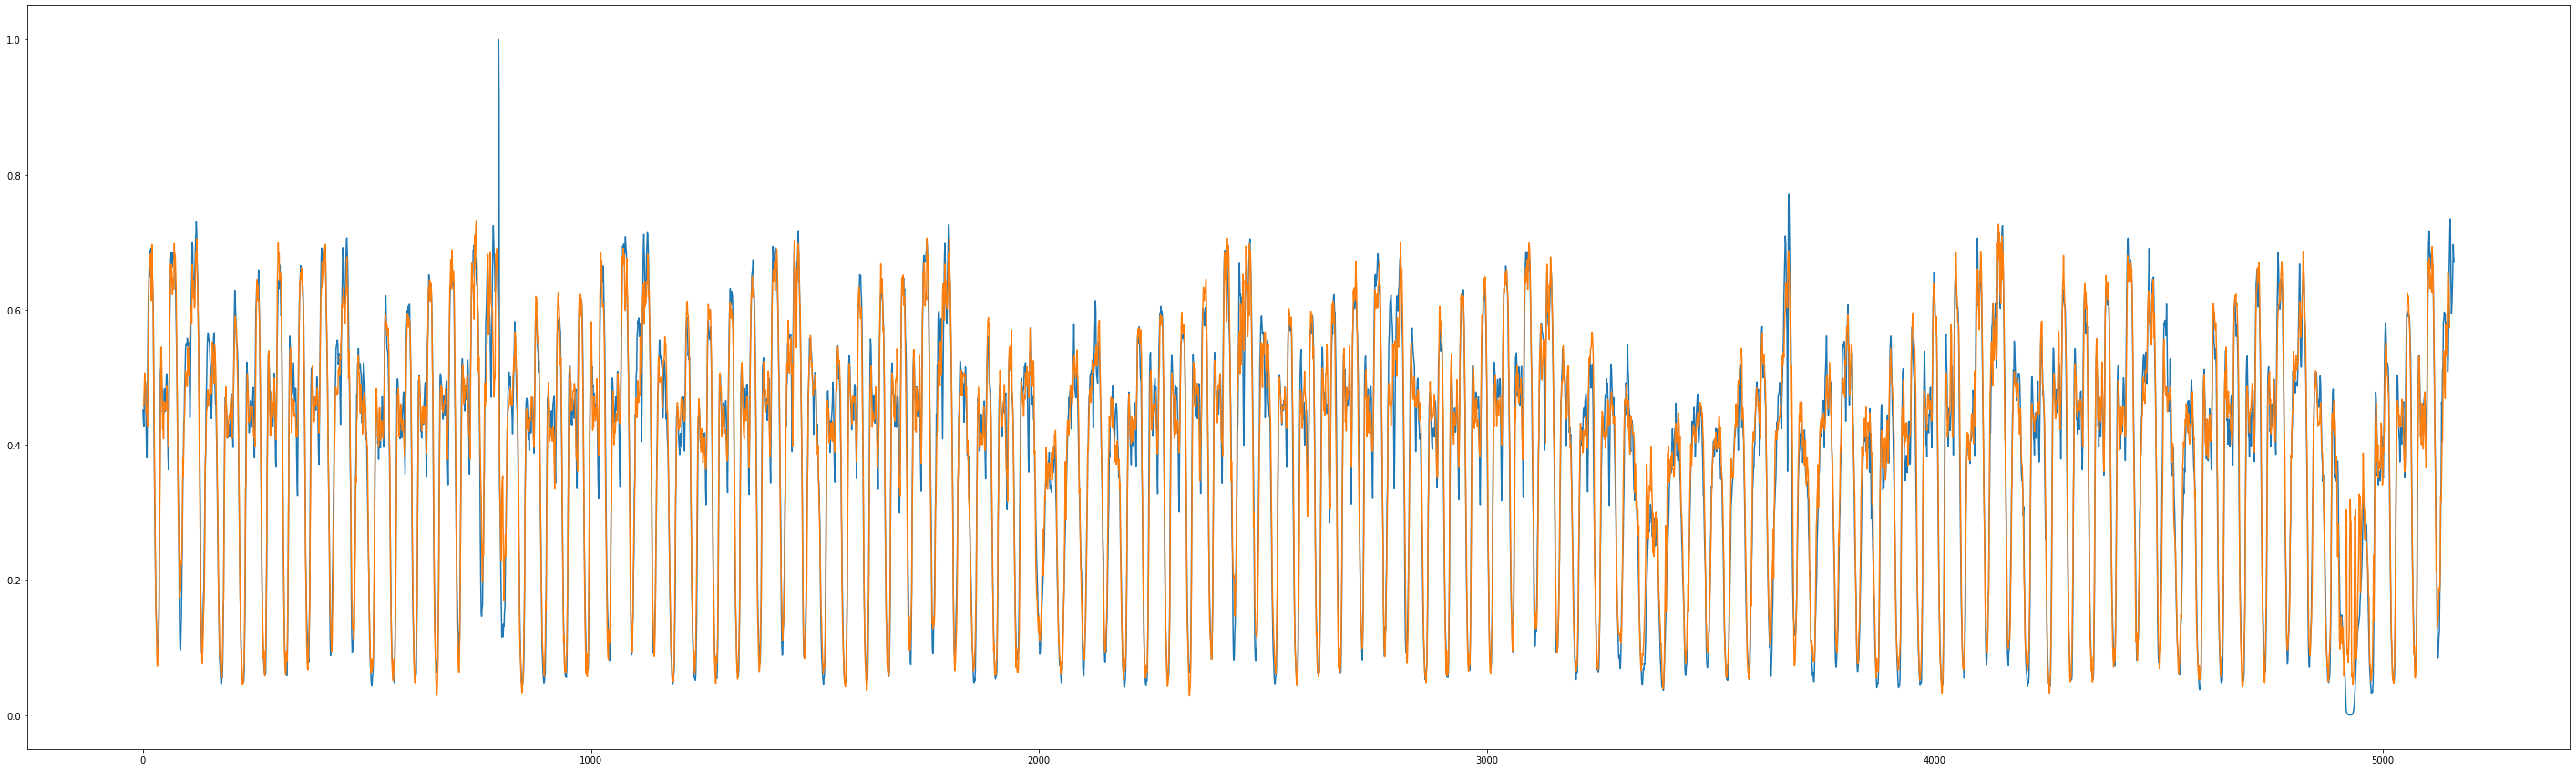

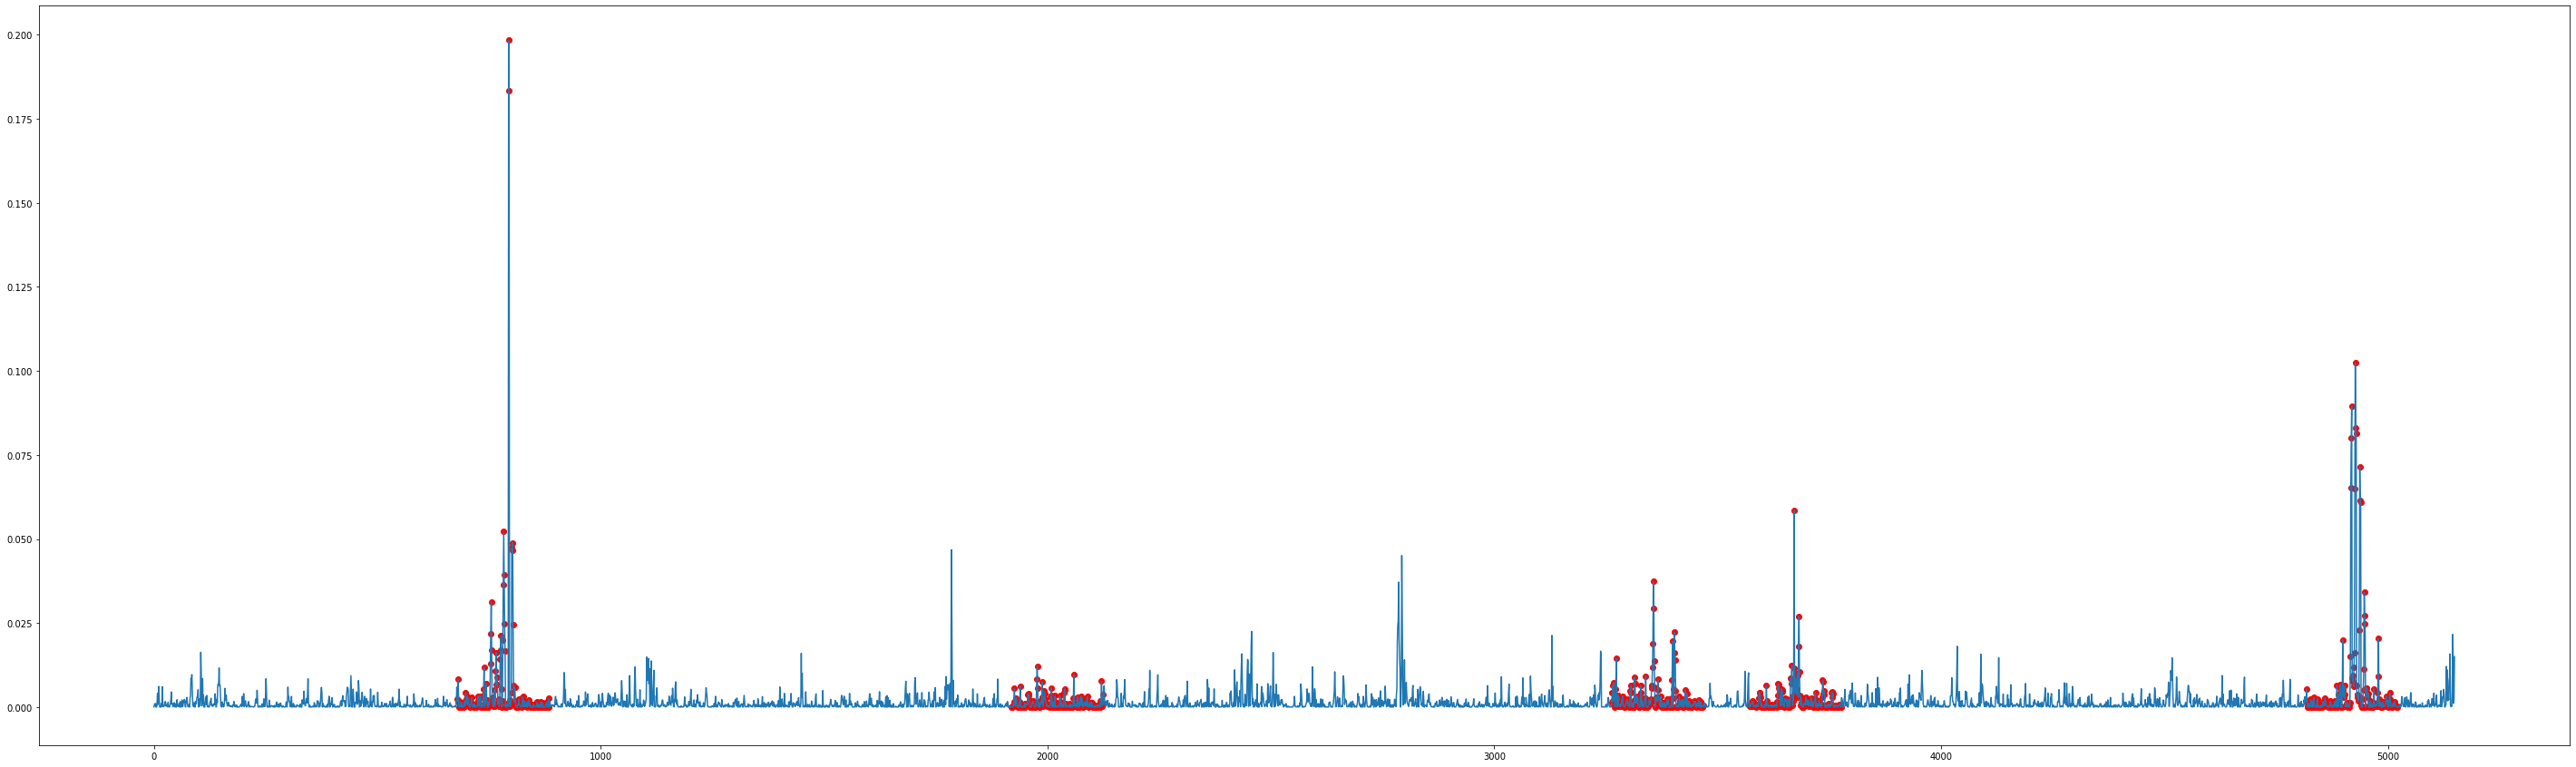

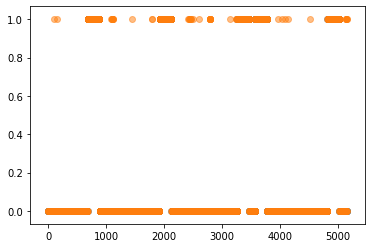

precision : 0.9572490706319703 recall : 1.0
aupr : 0.27738943426492363


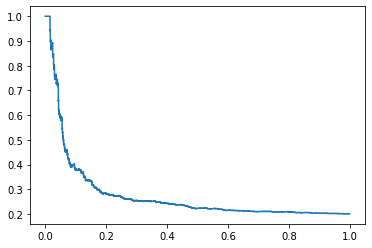

In [16]:
plot_error_and_anomaly_idxs(X_test_data, preds, anomaly_idxs_test)

real = real[:len(preds)]

scores = (preds - X_test_data[:len(preds)])**2

thresh = np.quantile(scores, .98)

anomaly_preds = evaluate_anomalies(real, scores, thresh)

plt.scatter(np.arange(len(real)),real,alpha=.5)
plt.scatter(np.arange(len(real)),anomaly_preds,alpha=.5)

plt.show()



#rates:
precision = precision_score(real, anomaly_preds)
recall = recall_score(real, anomaly_preds)
f1 = f1_score(real, anomaly_preds)
print('precision : ' + str(precision) + ' recall : ' + str(recall))

precision, recall, thresholds = precision_recall_curve(real, scores)

#todo later
aupr_scores = np.copy(scores)
aupr = average_precision_score(real,scores)

print('aupr : ' + str(aupr))

plt.plot(recall, precision)
plt.show()